# ATIVIDADE 2 -- PROCESSAMENTO DIGITAL DE IMAGENS



### INTEGRANTES
|**Participantes**|**RA**|
|-|-|
|Bruno Matos de Souza|769754|
|Gustavo M. Barreto|790832|
|Lucas Maciel Balieiro|800534|


## SEGMENTAÇÃO DOS PRINCIPAIS TECIDOS


In [18]:
ATLAS_IMG_DIR     = "Atlas"
CLINICS_IMG_DIR   = "imagens-clinicas"

ATLAS_MNI_REF = f"{ATLAS_IMG_DIR}/mni_ref.nii.gz"
ATLAS_MNI_CSF = f"{ATLAS_IMG_DIR}/mni_csf.nii.gz"
ATLAS_MNI_GM  = f"{ATLAS_IMG_DIR}/mni_gm.nii.gz"
ATLAS_MNI_WM  = f"{ATLAS_IMG_DIR}/mni_wm.nii.gz"

CLINICS_IMG_T1 = f"{CLINICS_IMG_DIR}/IXI002-Guys-0828-T1.nii.gz"
CLINICS_IMG_T2 = f"{CLINICS_IMG_DIR}/IXI012-HH-1211-T1.nii.gz"
CLINICS_IMG_T3 = f"{CLINICS_IMG_DIR}/IXI013-HH-1212-T1.nii.gz"
CLINICS_IMG_T4 = f"{CLINICS_IMG_DIR}/IXI014-HH-1236-T1.nii.gz"
CLINICS_IMG_T5 = f"{CLINICS_IMG_DIR}/IXI015-HH-1258-T1.nii.gz"

AtlasPaths = {
    "REF": ATLAS_MNI_REF,
    "CSF": ATLAS_MNI_CSF,
    "GM" : ATLAS_MNI_GM,
    "WM" : ATLAS_MNI_WM
}

ClinicalImgPaths  = [
    CLINICS_IMG_T1,
    CLINICS_IMG_T2,
    CLINICS_IMG_T3,
    CLINICS_IMG_T4,
    CLINICS_IMG_T5
]



### MÉTODO K-MEANS
Para este método, usaremos funções já implementadas do pacote `sckit-learn`.

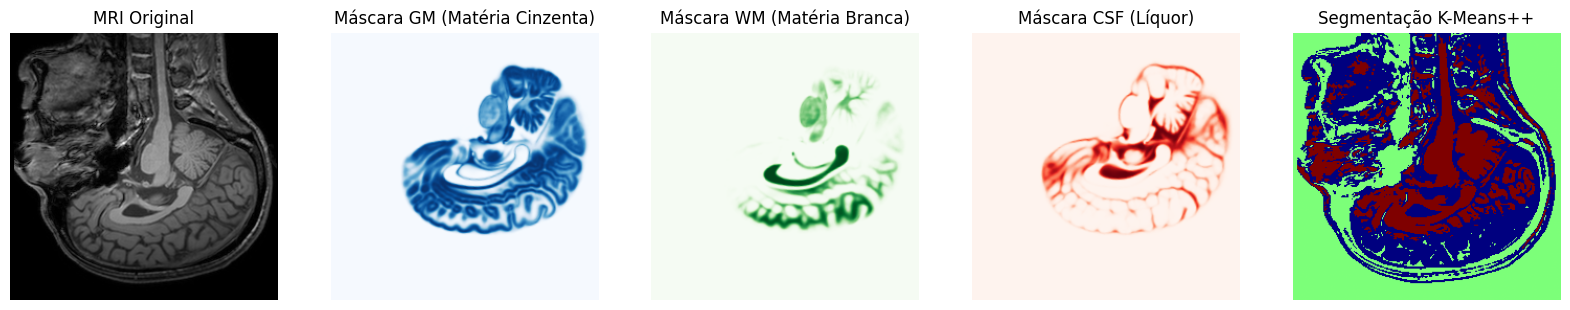

In [2]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def reorient_image(image, reference):
    return sitk.Resample(image, reference, sitk.Transform(), sitk.sitkLinear, 0.0, image.GetPixelID())

def align_mask(mask, reference_mri):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_mri)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)  # Mantém os valores discretos da máscara
    resampler.SetTransform(sitk.Transform())             # Usa a identidade para alinhamento
    aligned_mask = resampler.Execute(mask)
    return aligned_mask

def normalize_image(image_array: np.ndarray):
    mx = np.max(image_array)
    mn = np.min(image_array)
    
    return (image_array - mn) / (mx - mn)


# Passo 1: Carregar a Imagem de MRI e as Máscaras
image_path    = ClinicalImgPaths[1]
mask_gm_path  = ATLAS_MNI_GM
mask_wm_path  = ATLAS_MNI_WM
mask_csf_path = ATLAS_MNI_CSF

# Ler imagens
sitk_image = sitk.ReadImage(image_path)
image_array = sitk.GetArrayFromImage(sitk_image)

mask_gm  = sitk.ReadImage(mask_gm_path)
mask_wm  = sitk.ReadImage(mask_wm_path)
mask_csf = sitk.ReadImage(mask_csf_path)

#alteramos orientacao da imagem
mask_gm  = reorient_image(mask_gm, sitk_image)
mask_wm  = reorient_image(mask_wm, sitk_image)
mask_csf = reorient_image(mask_csf, sitk_image)

# obtemos o array da img normalizada
mask_gm  = normalize_image(sitk.GetArrayFromImage(mask_gm))
mask_wm  = normalize_image(sitk.GetArrayFromImage(mask_wm))
mask_csf = normalize_image(sitk.GetArrayFromImage(mask_csf))


# Passo 2: Aplicar K-Means++ para Segmentação
depth, height, width = image_array.shape
flat_image = image_array.reshape(-1, 1)

n_clusters = 3  # GM, WM, CSF
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
kmeans.fit(flat_image)

# Obter rótulos e reconstruir a imagem segmentada
segmented_labels = kmeans.labels_
segmented_image = segmented_labels.reshape(depth, height, width)

# Passo 3: Plotar as 3 Máscaras e a Segmentação
slice_index = depth // 2  # Seleciona a fatia central

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Imagem Original
axes[0].imshow(image_array[slice_index], cmap="gray")
axes[0].set_title("MRI Original")
axes[0].axis("off")

# Máscara GM
axes[1].imshow(mask_gm[slice_index], cmap="Blues")
axes[1].set_title("Máscara GM (Matéria Cinzenta)")
axes[1].axis("off")

# Máscara WM
axes[2].imshow(mask_wm[slice_index], cmap="Greens")
axes[2].set_title("Máscara WM (Matéria Branca)")
axes[2].axis("off")

# Máscara CSF
axes[3].imshow(mask_csf[slice_index], cmap="Reds")
axes[3].set_title("Máscara CSF (Líquor)")
axes[3].axis("off")

# Segmentação K-Means++
axes[4].imshow(segmented_image[slice_index], cmap="jet")
axes[4].set_title("Segmentação K-Means++")
axes[4].axis("off")

plt.show()


### MÉTODO GAUSSIAN MIXTURE MODEL



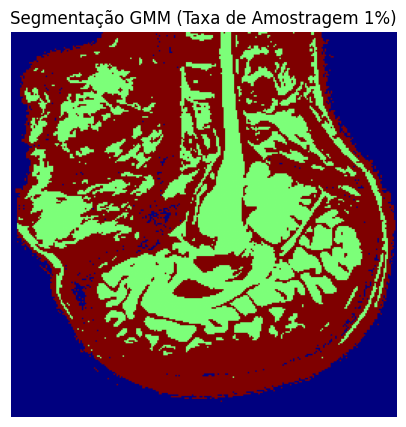

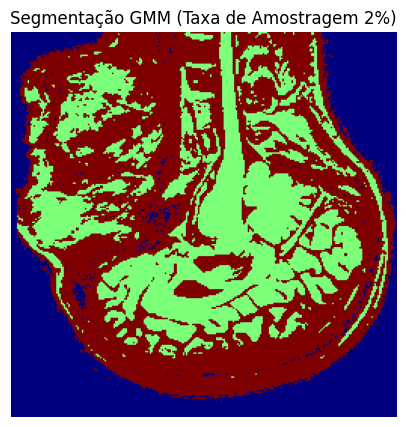

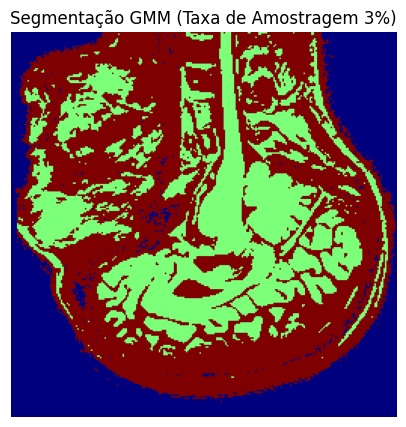

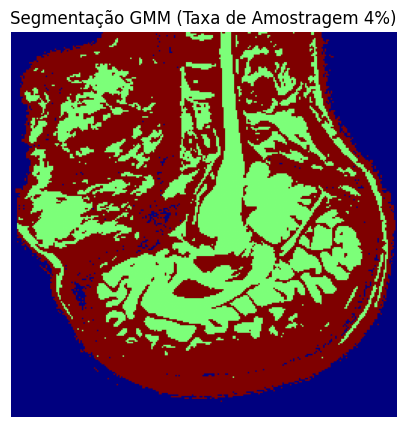

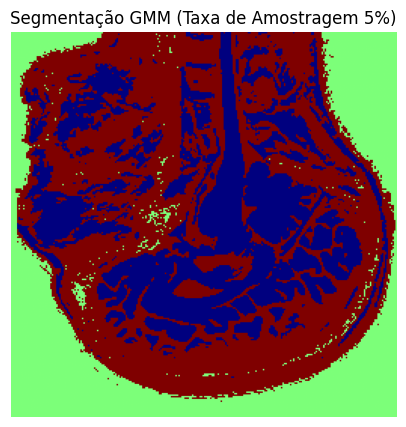


Comparação Final dos Volumes de Tecido (em mm³):
                      Tecido 0    Tecido 1    Tecido 2
Taxa de Amostragem                                    
1%                  4808090.72  2224966.81  3334972.75
2%                  4808090.72  2337808.16  3222131.40
3%                  4808090.72  2257328.94  3302610.62
4%                  4808090.72  2176730.54  3383209.02
5%                  2240999.16  4808090.72  3318940.40

Diferença Percentual em Relação à Taxa de Amostragem de 1%:
                    Tecido 0  Tecido 1  Tecido 2
Taxa de Amostragem                              
1%                      0.00      0.00      0.00
2%                      0.00      5.07     -3.38
3%                      0.00      1.45     -0.97
4%                      0.00     -2.17      1.45
5%                    -53.39    116.10     -0.48


In [20]:
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
import pandas as pd  

def calculate_volume(segmented_image, voxel_spacing):
    """Calcula o volume de cada tecido cerebral em mm³ usando o tamanho do voxel."""
    voxel_volume = np.prod(voxel_spacing)  # Produto das dimensões espaciais do voxel (em mm³)
    unique, counts = np.unique(segmented_image, return_counts=True)
    volume_dict = {f"Tecido {u}": round(c * voxel_volume, 2) for u, c in zip(unique, counts)}
    return volume_dict

# Obter o tamanho do voxel da imagem
voxel_spacing = sitk_image.GetSpacing() 

# Refazer o loop de amostragem com o cálculo volumétrico refinado
sampling_rates = [0.01, 0.02, 0.03, 0.04, 0.05]
comparison_results = []

for rate in sampling_rates:
    # Amostragem da imagem original
    sampled_flat_image = resample(flat_image, n_samples=int(flat_image.shape[0] * rate), random_state=42)
    
    # Segmentação com GMM usando inicialização por K-Means++
    gmm_kmeans = GaussianMixture(n_components=n_clusters, init_params='kmeans', random_state=42)
    gmm_kmeans.fit(sampled_flat_image)
    
    # Obter rótulos e reconstruir a imagem segmentada
    gmm_labels = gmm_kmeans.predict(flat_image)
    gmm_segmented_image = gmm_labels.reshape(depth, height, width)
    
    # Calcular volume para cada tecido
    volume_result = calculate_volume(gmm_segmented_image, voxel_spacing)
    
    # Armazenar resultados para comparação
    comparison_results.append({
        "Taxa de Amostragem": f"{int(rate * 100)}%",
        **volume_result  # Adiciona o volume de cada tecido ao dicionário
    })
    
    # Exibir a fatia central para cada taxa de amostragem
    plt.figure(figsize=(10, 5))
    plt.imshow(gmm_segmented_image[slice_index], cmap="jet")
    plt.title(f"Segmentação GMM (Taxa de Amostragem {int(rate * 100)}%)")
    plt.axis("off")
    plt.show()

# Criar um DataFrame para comparação final
df_comparison = pd.DataFrame(comparison_results)
df_comparison.set_index("Taxa de Amostragem", inplace=True)

# Exibir a tabela de comparação
print("\nComparação Final dos Volumes de Tecido (em mm³):")
print(df_comparison)

# Opcional: Exibir a diferença percentual relativa ao volume obtido na primeira taxa de amostragem (1%)
initial_volumes = df_comparison.iloc[0]
df_percentage_diff = ((df_comparison - initial_volumes) / initial_volumes) * 100

print("\nDiferença Percentual em Relação à Taxa de Amostragem de 1%:")
print(df_percentage_diff.round(2))




### AVALIAÇÃO -- VARIAÇÃO DA TX. AMOSTRAL



Volume de cada tecido (GMM com inicialização pelo atlas probabilístico):
Tecido 0: 3365732.80 mm³
Tecido 1: 4751512.90 mm³
Tecido 2: 2250784.58 mm³


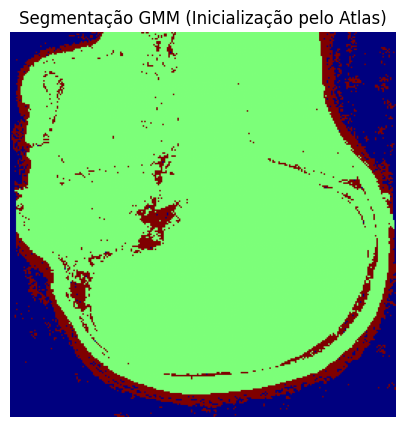

In [17]:
def initialize_gmm_with_atlas(image_array, mask_gm, mask_wm, mask_csf):
    """Calcula as médias e matrizes de covariância iniciais do GMM usando o atlas probabilístico."""
    masks = [mask_gm, mask_wm, mask_csf]
    means = []
    precisions = []

    for mask in masks:
        tissue_values = image_array[mask > 0.5]
        mean = tissue_values.mean()
        variance = tissue_values.var()
        
        means.append(mean)
        # A matriz de precisão para um único recurso é simplesmente 1/variância, mas precisa estar no formato (1, 1)
        precisions.append(1 / variance)
    
    means = np.array(means).reshape(-1, 1)  # Shape: (3, 1)
    precisions = np.array(precisions).reshape(3, 1, 1)  # Shape: (3, 1, 1)
    
    return means, precisions


# Inicializar o GMM com atlas probabilístico
means_init, precisions_init = initialize_gmm_with_atlas(image_array, mask_gm, mask_wm, mask_csf)

# Aplicar o GMM usando as inicializações do atlas
gmm_atlas = GaussianMixture(n_components=3, covariance_type='full', means_init=means_init, precisions_init=precisions_init, random_state=42)
gmm_atlas.fit(flat_image)

# Obter rótulos e reconstruir a imagem segmentada
gmm_atlas_labels = gmm_atlas.predict(flat_image)
gmm_atlas_segmented_image = gmm_atlas_labels.reshape(depth, height, width)

# Calcular o volume usando a inicialização do atlas
volume_result_atlas = calculate_volume(gmm_atlas_segmented_image, voxel_spacing)

# Exibir os resultados
print("Volume de cada tecido (GMM com inicialização pelo atlas probabilístico):")
for tissue, volume in volume_result_atlas.items():
    print(f"{tissue}: {volume:.2f} mm³")

# Plotar a segmentação usando inicialização do atlas
plt.figure(figsize=(10, 5))
plt.imshow(gmm_atlas_segmented_image[slice_index], cmap="jet")
plt.title("Segmentação GMM (Inicialização pelo Atlas)")
plt.axis("off")
plt.show()
